# **Caltech - Machine Learning Course**

## LAB:  Australian Apparel Ltd

### NOTEBOOK:  Data Wrangling
### Project Statement
AAL, established in 2000, is a well-known brand in Australia, particularly recognized for its clothing business. It has opened branches in various states, metropolises, and tier-1 and tier-2 cities across the country.
The brand caters to all age groups, from kids to the elderly.
Currently experiencing a surge in business, AAL is actively pursuing expansion opportunities. To facilitate informed investment decisions, the CEO has assigned the responsibility to the head of AAL’s sales and marketing (S&M) department. The specific tasks include:
1)	Identify the states that are generating the highest revenues.
2)	Develop sales programs for states with lower revenues. The head of sales and marketing has requested your assistance with this task.
Analyze the sales data of the company for the fourth quarter in Australia, examining it on a state-by-state basis. Provide insights to assist the company in making data-driven decisions for the upcoming year.

### Notebook Objective
Data visualization
a.	Use suitable data visualization libraries to construct a dashboard for the head of sales and marketing. The dashboard should encompass key parameters:
    - State-wise sales analysis for different demographic groups (kids, women, men, and seniors).
    - Group-wise sales analysis (Kids, Women, Men, and Seniors) across various states.
    - Time-of-the-day analysis: Identify peak and off-peak sales periods to facilitate strategic planning for S&M teams. This information aids in designing programs like hyper-personalization and Next Best Offers to enhance sales.
b.	Ensure the visualization is clear and accessible for effective decision-making by the head of sales and marketing (S&M).
The dashboard must contain daily, weekly, monthly, and quarterly charts.
(Any visualization library can be used for this purpose. However, since statistical analysis is being done, Seaborn is preferred.)
c.	Include your recommendation and indicate why you are choosing the recommended visualization package.

<hr/>



Time
Morning      114207500
Afternoon    114007500
Evening      112087500
Name: Sales, dtype: int64


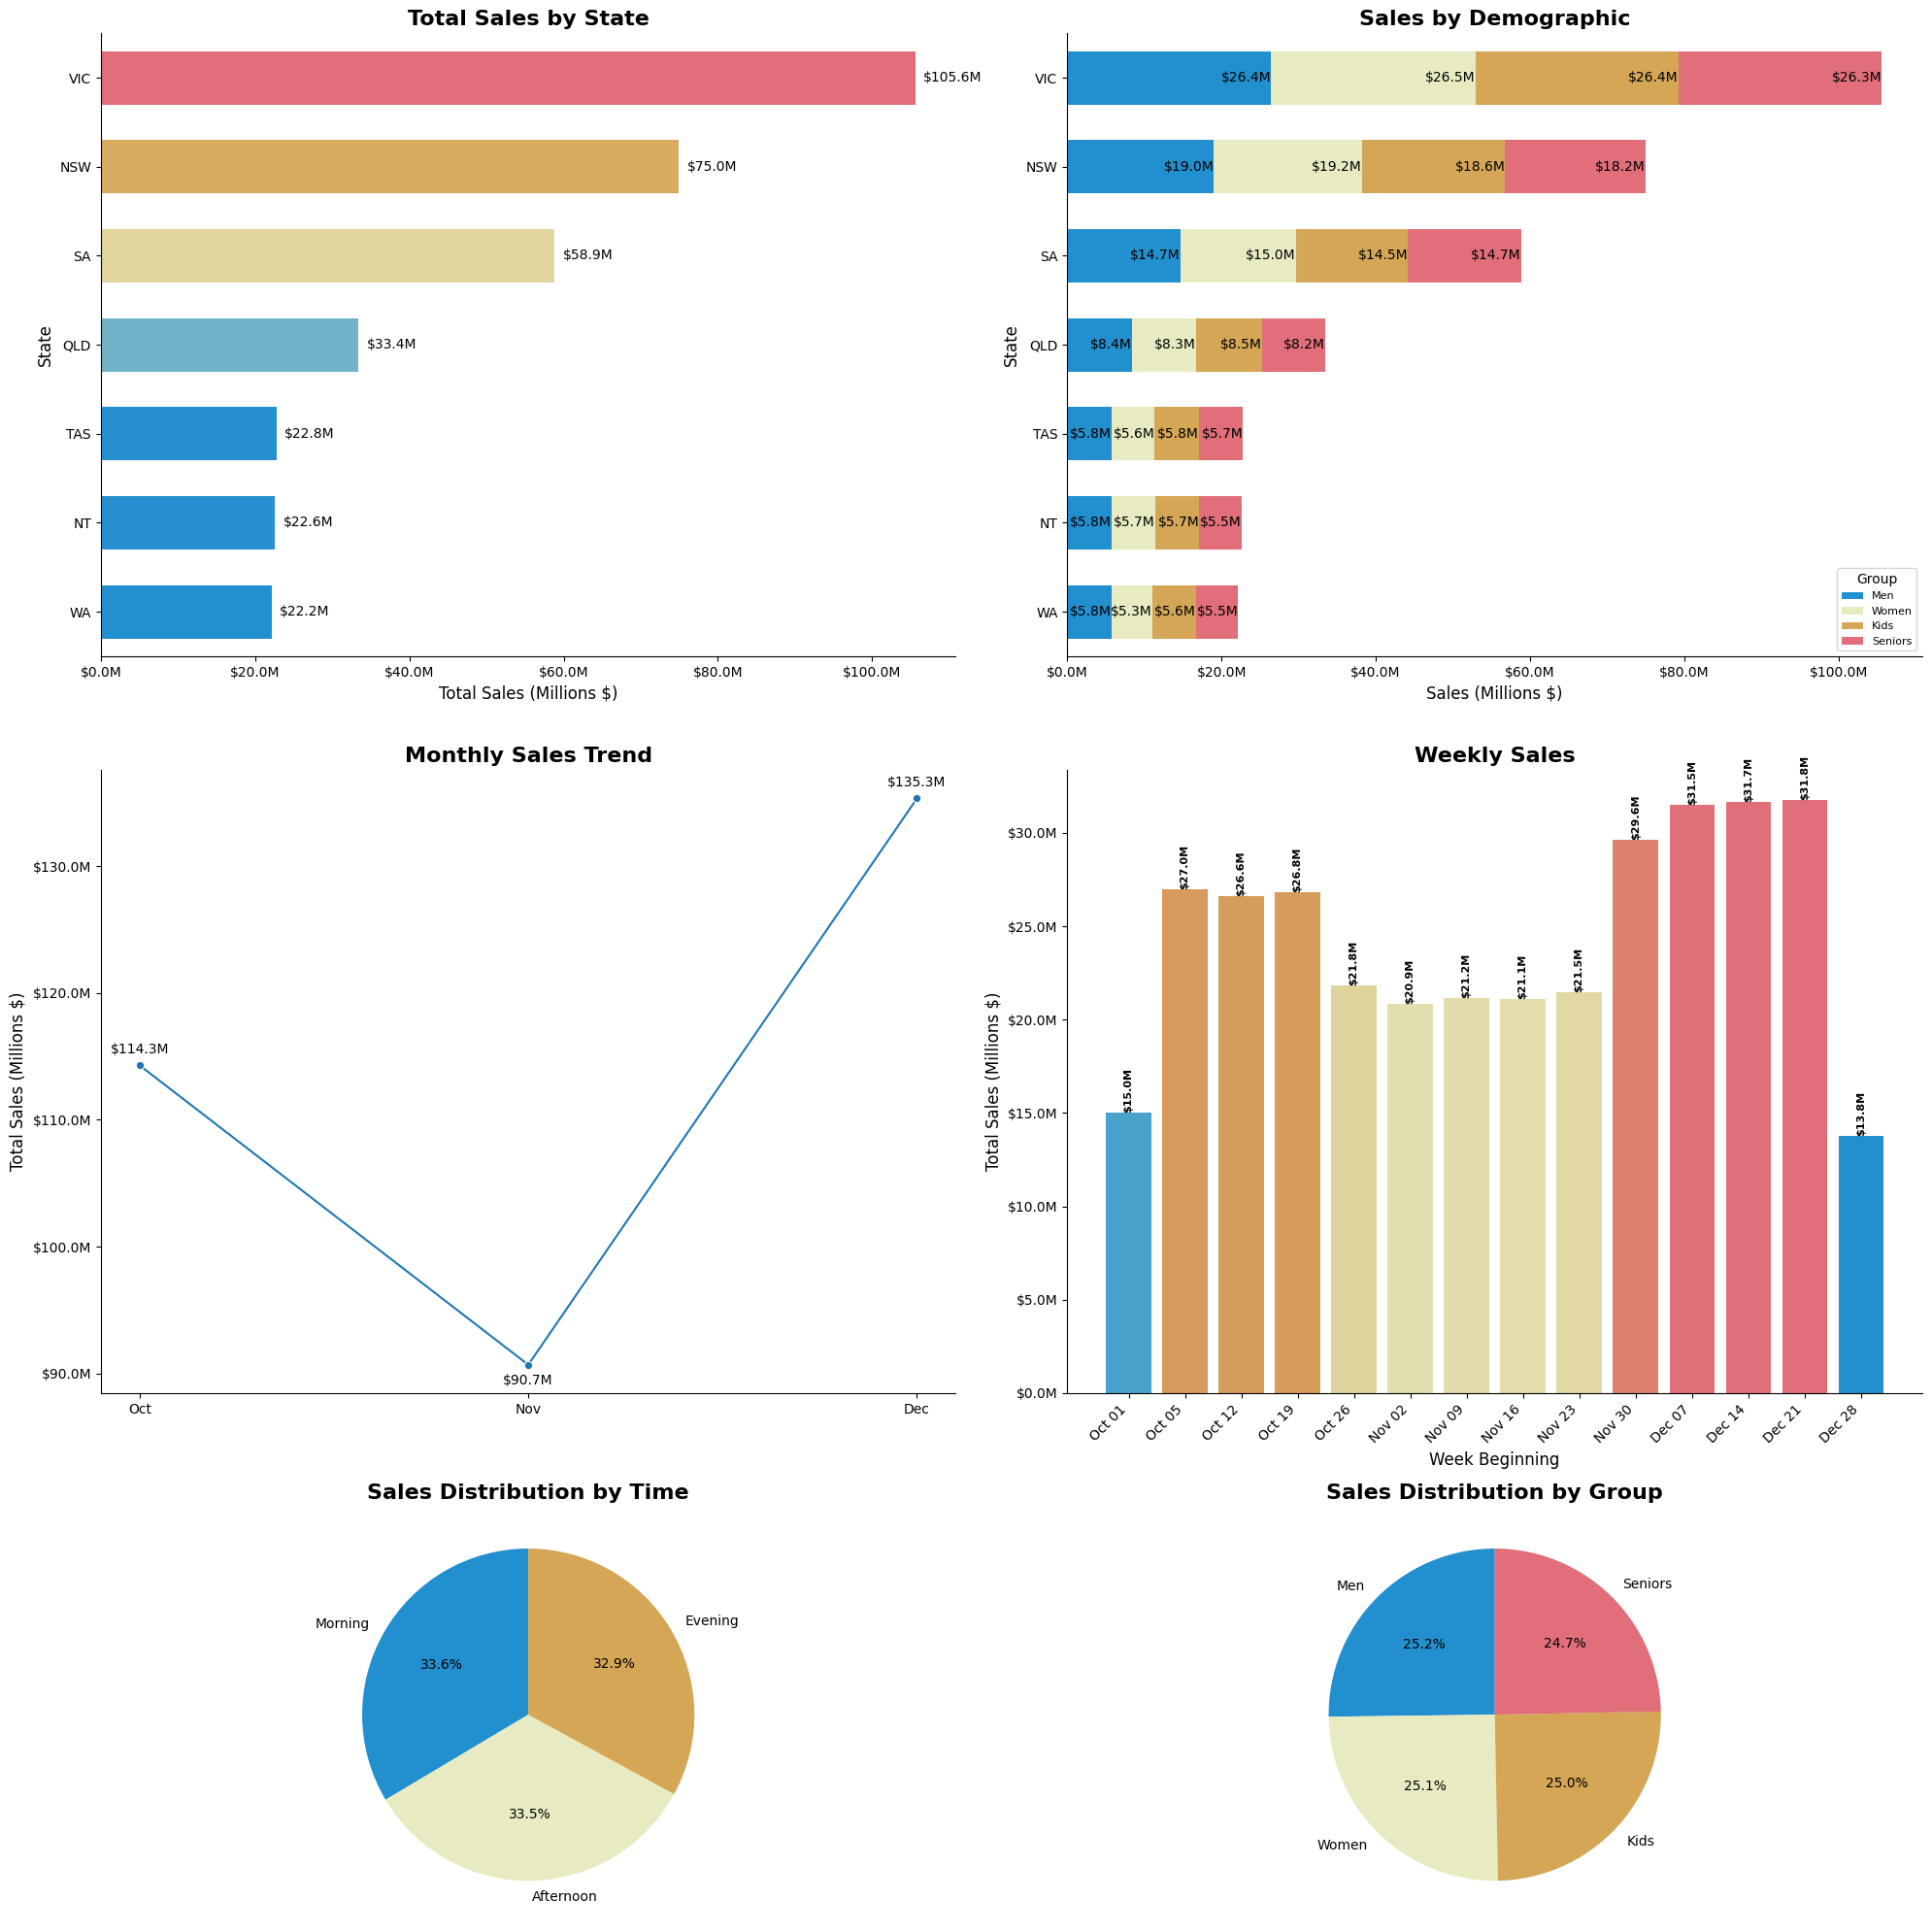

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer
from typing import Tuple, List


# FORMATTING
# These functions were added ti reduce code repetition and improve readability.
def format_millions(x: float, p) -> str:
    return f'${x/1e6:.1f}M'

def remove_spines(ax: plt.Axes) -> None:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def create_color_map(data: pd.Series, colors: List[str]) -> Tuple[plt.cm.colors.LinearSegmentedColormap, plt.Normalize]:
    norm = plt.Normalize(data.min(), data.max())
    return plt.cm.colors.LinearSegmentedColormap.from_list("", colors), norm

def create_horizontal_bar_plot(ax: plt.Axes, data: pd.Series, title: str, xlabel: str, ylabel: str, bar_height: float, colors: np.ndarray) -> BarContainer:
    bars = ax.barh(y=data.index, width=data.values, height=bar_height, color=colors)
    ax.set_title(title, **plot_style['title'])
    ax.set_xlabel(xlabel, **plot_style['label'])
    ax.set_ylabel(ylabel, **plot_style['label'])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_millions))
    remove_spines(ax)
    return bars

# STYLE 
#This dictionary defines styling used for plotting.
plot_style: dict = {
    'title': {'fontsize': 16, 'fontweight': 'bold'},
    'label': {'fontsize': 12},
    'tick': {'fontsize': 10},
    'legend': {'fontsize': 8, 'title_fontsize': 10}
}


# LOAD Data
# Load the dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Load the data
df: pd.DataFrame = pd.read_csv('../data/AusApparalSales4thQrt2020cln.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.strftime('%b')


# Data Aggregations
state_sales: pd.Series = df.groupby('State')['Sales'].sum().sort_values(ascending=True)
state_demo_sales: pd.DataFrame = df.groupby(['State', 'Group'])['Sales'].sum().unstack()

# Ensure all demographic groups are present as columns
for group in ['Men', 'Women', 'Kids', 'Seniors']:
    if group not in state_demo_sales.columns:
        state_demo_sales[group] = 0

state_demo_sales = state_demo_sales[['Men', 'Women', 'Kids', 'Seniors']]
state_demo_sales = state_demo_sales.reindex(state_sales.index)
monthly_sales: pd.Series = df.groupby('Month')['Sales'].sum()
weekly_sales: pd.Series = df.groupby('Week')['Sales'].sum()
time_sales: pd.Series = df.groupby('Time')['Sales'].sum().reindex(['Morning', 'Afternoon', 'Evening'], fill_value=0)
print(time_sales)
group_sales: pd.Series = df.groupby('Group')['Sales'].sum().reindex(['Men', 'Women', 'Kids', 'Seniors'])

# Create a dictionary to map week numbers to their start dates
week_to_date: pd.Series = df.groupby('Week')['Date'].min().dt.strftime('%b %d')

# Set up the plot
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(3, 2, height_ratios=[1.5, 1.5, 1])

# PLOT: Total Sales by State
def plot_total_sales_by_state(ax: plt.Axes, state_sales: pd.Series) -> plt.Axes:
    color_map, norm = create_color_map(state_sales, colors)
    bars = create_horizontal_bar_plot(ax, state_sales, 'Total Sales by State', 
                                      'Total Sales (Millions $)', 'State', 0.6, 
                                      color_map(norm(state_sales.values)))
    
    # Add value labels
    for i, v in enumerate(state_sales.values):
        ax.text(v + (state_sales.max() * 0.01), i, format_millions(v, None), 
                va='center', ha='left', **plot_style['tick'])
    
    return ax

ax1 = fig.add_subplot(gs[0, 0])
ax1 = plot_total_sales_by_state(ax1, state_sales)

# PLOT: Sales by Demographic
def plot_sales_by_demographic(ax: plt.Axes, state_demo_sales: pd.DataFrame) -> plt.Axes:
    left = np.zeros(len(state_demo_sales))
    for i, column in enumerate(state_demo_sales.columns):
        ax.barh(state_demo_sales.index, state_demo_sales[column], left=left, height=0.6, 
                label=column, color=colors[i])
        left += state_demo_sales[column]

    ax.set_title('Sales by Demographic', **plot_style['title'])
    ax.set_xlabel('Sales (Millions $)', **plot_style['label'])
    ax.set_ylabel('State', **plot_style['label'])
    ax.legend(title='Group', loc='lower right', **plot_style['legend'])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_millions))
    remove_spines(ax)

    # Add value labels
    for i, (name, row) in enumerate(state_demo_sales.iterrows()):
        cumulative_sum = 0
        for group, sales in row.items():
            cumulative_sum += sales
            ax.text(cumulative_sum, i, format_millions(sales, None), 
                    va='center', ha='right', **plot_style['tick'])
    
    return ax

ax2 = fig.add_subplot(gs[0, 1])
ax2 = plot_sales_by_demographic(ax2, state_demo_sales)

# Set the Total Sales by State and Sales by Demographic Group for each State plots have the same y-axis limits
ax1.set_ylim(-0.5, len(state_sales) - 0.5)
ax2.set_ylim(-0.5, len(state_sales) - 0.5)

# PLOT: Monthly Sales Trend
def plot_monthly_sales_trend(ax: plt.Axes, monthly_sales: pd.Series) -> plt.Axes:
    month_order = ['Oct', 'Nov', 'Dec']
    monthly_sales_ordered = monthly_sales.reindex(month_order)
    sns.lineplot(x=monthly_sales_ordered.index, y=monthly_sales_ordered.values, ax=ax, marker='o')
    ax.set_title('Monthly Sales Trend', **plot_style['title'])
    ax.set_ylabel('Total Sales (Millions $)', **plot_style['label'])
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))
    ax.tick_params(axis='x', rotation=0)
    remove_spines(ax)

    # Add value labels
    for i, v in enumerate(monthly_sales_ordered.values):
        va = 'top' if month_order[i] == 'Nov' else 'bottom'
        offset = -0.005 * ax.get_ylim()[1] if month_order[i] == 'Nov' else 0.005 * ax.get_ylim()[1]
        ax.text(i, v + offset, format_millions(v, None), ha='center', va=va, **plot_style['tick'])
    
    return ax

ax3 = fig.add_subplot(gs[1, 0])
ax3 = plot_monthly_sales_trend(ax3, monthly_sales)

# PLOT: Weekly Sales Comparison
def plot_weekly_sales_comparison(ax: plt.Axes, weekly_sales: pd.Series, week_to_date: pd.Series) -> plt.Axes:
    color_map, norm = create_color_map(weekly_sales, colors)
    x = range(len(weekly_sales))
    bars = ax.bar(x, weekly_sales.values, color=color_map(norm(weekly_sales.values)))
    ax.set_title('Weekly Sales', **plot_style['title'])
    ax.set_xlabel('Week Beginning', **plot_style['label'])
    ax.set_ylabel('Total Sales (Millions $)', **plot_style['label'])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))
    ax.set_xticks(x)
    ax.set_xticklabels([week_to_date[week] for week in weekly_sales.index], rotation=45, ha='right')
    remove_spines(ax)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, format_millions(height, None),
                ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=90)
    
    return ax

ax4 = fig.add_subplot(gs[1, 1])
ax4 = plot_weekly_sales_comparison(ax4, weekly_sales, week_to_date)

# PLOT: Sales Distribution by Time of Day

def plot_sales_by_time_of_day(ax: plt.Axes, time_sales: pd.Series) -> plt.Axes:
    time_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors, ax=ax)
    ax.set_title('Sales Distribution by Time', **plot_style['title'])
    ax.set_ylabel('')
    return ax

ax5 = fig.add_subplot(gs[2, 0])
ax5 = plot_sales_by_time_of_day(ax5, time_sales)

# PLOT: Sales Distribution by Customer Group
def plot_sales_by_customer_group(ax: plt.Axes, group_sales: pd.Series) -> plt.Axes:
    group_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors, ax=ax)
    ax.set_title('Sales Distribution by Group', **plot_style['title'])
    ax.set_ylabel('')
    return ax

ax6 = fig.add_subplot(gs[2, 1])
ax6 = plot_sales_by_customer_group(ax6, group_sales)

plt.tight_layout()
plt.show()

## Summary of Sales findings:

### Sales by State
**Findings**
- VIC has the largest sales volume at $105M, with NSW ($75M) and SA ($58.9M) trailing.  TAS, NT, WA have much lower sales volume in the $22M range.

**Recommended Visualization**
- A Horizontal Bar chart was used to provide an at-a-glance comparison of Sales by State.
- Sorting the results highlights the States with highest Sales and Lowest sales.
- Adding the numeric values helps provide scale to the Sales volume.

### Sales by Demographic
**Findings**
- Sales is fairly evenly distributed across all Demographic groups across all States.

**Recommended Visualization**
- A Stacked Horizonal Bar chart was used to provide a comparison Sales volume along with Demographic information by State.
- Sorting the results highlights the States with highest Sales and Lowest sales.
- Color coding each Demographic makes the chart more readable.
- Adding the Demographic numeric values helps provide scale to the each group.

### Sales Trends
**Findings**
- Sales surge in December, likely due to Holiday or other seasonality.

**Recommended Visualization**
- A Line Plot was used to show the Trend over time.
- Monthly markers were added to show the time interval.
- Adding the numeric values helps provide scale to the Sales volume over time.

### Weekly Sales
**Findings**
- Sales surge in October and again in December, likely due to seasonality.

**Recommended Visualization**

### Sales by Time
**Findings**
- Sales are relatively evenly distributed throughout the day at 33% for each segment.

**Recommended Visualization**
- A Pie Chart was used to show Percentage of sales by Time of Day

### Sales by Group
**Findings**
- As seen in the Demographics, sales are fairly evenly distributed across Groups.

**Recommended Visualization**
- A Pie Chart was used to show Percentage of sales by Demographic group


